In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

%matplotlib inline

2023-08-22 19:55:25.834934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 19:55:27.426288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Part 2. Backtesting

In [2]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']


In [3]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_sac = True

In [4]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

In [5]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [6]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [7]:
trade

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.250435,110737200.0,2.0,2.992670,92.024810,79.596532,62.807161,107.503400,29.730532,83.323037,77.152043,28.620001,53.068015
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,230.553375,6575800.0,2.0,3.491020,223.106913,192.209086,61.279638,270.449978,46.806139,206.269306,207.299417,28.620001,53.068015
0,2020-07-01,AXP,95.250000,96.959999,93.639999,90.432198,3301000.0,2.0,-0.382171,108.440349,86.182875,48.504820,-66.291609,3.142448,95.497790,89.066325,28.620001,53.068015
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068015
0,2020-07-01,CAT,129.380005,129.399994,125.879997,117.235703,2807800.0,2.0,1.236598,126.925995,110.143821,52.865424,35.746627,14.457404,116.031969,110.429062,28.620001,53.068015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2021-10-27,UNH,454.640015,460.440002,453.480011,442.888275,3520400.0,2.0,11.389334,453.317599,363.583100,65.085948,174.334935,51.571330,405.454169,405.739810,16.980000,145.285221
334,2021-10-27,V,224.750000,224.750000,215.660004,212.550888,22958100.0,2.0,0.013828,233.490236,215.279985,41.737207,-153.711177,30.337021,223.493653,225.707213,16.980000,145.285221
334,2021-10-27,VZ,53.169998,53.200001,52.470001,47.476547,15007400.0,2.0,-0.220521,49.223191,46.156535,44.604910,-50.018824,8.504850,47.925124,48.541796,16.980000,145.285221


In [8]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [9]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [10]:
e_trade_gym.action_space

Box(-1.0, 1.0, (29,), float32)

In [11]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [12]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [13]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [14]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


In [15]:
df_actions_a2c

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,54,50,0,20,0,0,0,70,0,0,...,100,0,0,0,100,0,100,51,100,0
2020-07-02,54,50,0,20,0,0,0,70,0,0,...,100,0,0,0,100,0,100,51,100,0
2020-07-06,54,50,0,20,0,0,0,70,0,0,...,100,0,0,0,100,0,100,51,100,0
2020-07-07,54,50,0,20,0,0,0,70,0,0,...,100,0,0,0,100,0,100,51,100,0
2020-07-08,54,50,0,20,0,0,0,70,0,0,...,100,0,0,0,100,0,100,51,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 5: Backtesting Results

In [16]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "sac": df_result_sac["account_value"] if if_using_sac else None,
    }
)


<Figure size 1500x500 with 0 Axes>

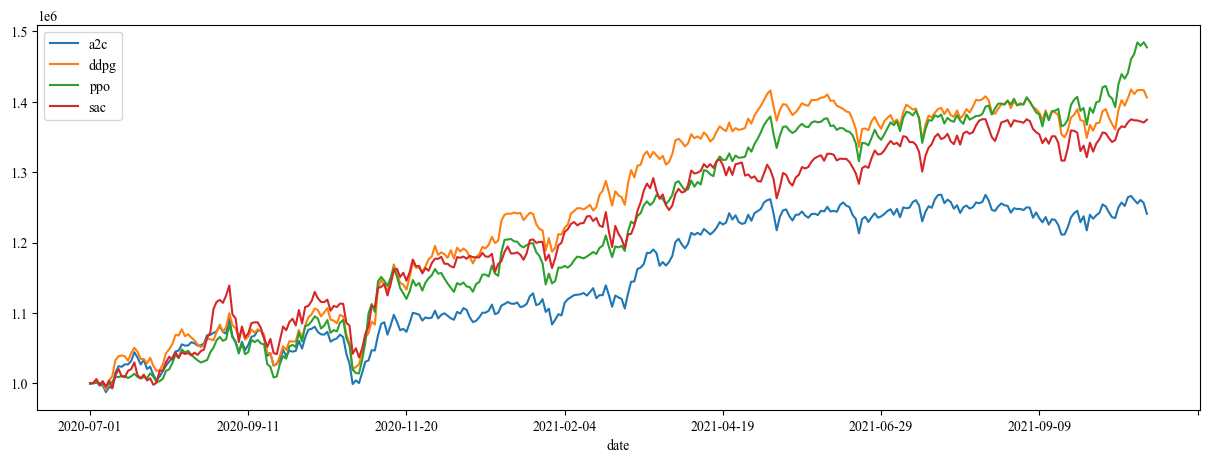

In [17]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()
plt.savefig('./results/models.png')

In [18]:
rewards_a2c = list()
turbulence_a2c = list()
cost_a2c = list()
trade_a2c = list()

obs = e_trade_gym.reset()[0]
# print(obs[0])
while True:
    action1, _states1 = trained_a2c.predict(obs)
    obs, rewards, done, info, new = e_trade_gym.step(np.array(action1))
    print('rewards', rewards)
    rewards_a2c.append(rewards)
    print('turbulence', e_trade_gym.turbulence)
    turbulence_a2c.append(e_trade_gym.turbulence)
    print('trade:', e_trade_gym.trades)
    trade_a2c.append(e_trade_gym.trades)
    print('cost:', e_trade_gym.cost)
    cost_a2c.append(e_trade_gym.cost)
    if done:
        print(done)
        print(info)
        print(new)
        break
e_trade_gym.asset_memory[-1]

rewards 0.03113716656494653
turbulence 27.68000030517578
trade: 13
cost: 125.30327636718751
rewards 0.3662239290721715
turbulence 27.940000534057617
trade: 30
cost: 284.3914125556946
rewards -0.7393740833351156
turbulence 29.43000030517578
trade: 50
cost: 459.69716442489613
rewards 0.13567126853637165
turbulence 28.07999992370605
trade: 73
cost: 667.2160693321227
rewards -0.9583369950416615
turbulence 29.26000022888184
trade: 94
cost: 854.3416006507874
rewards 0.7354322282940033
turbulence 27.290000915527344
trade: 115
cost: 1020.8388405685427
rewards -0.2847512890625047
turbulence 32.189998626708984
trade: 139
cost: 1247.224179161072
rewards 2.221222654237738
turbulence 29.520000457763672
trade: 164
cost: 1459.8555469398498
rewards 0.9284907585678157
turbulence 27.76000022888184
trade: 189
cost: 1581.25422423172
rewards -0.05060127131805057
turbulence 28.0
trade: 211
cost: 1694.5695344581607
rewards 0.3234075091251289
turbulence 25.68000030517578
trade: 234
cost: 1808.2073567199714
re

1222302.3343868274

In [19]:
rewards_ppo = list()
turbulence_ppo = list()
cost_ppo = list()
trade_ppo = list()

obs = e_trade_gym.reset()[0]
# print(obs[0])
while True:
    action2, _states2 = trained_ppo.predict(obs)
    obs, rewards, done, info, new = e_trade_gym.step(np.array(action2))
    print('rewards', rewards)
    rewards_ppo.append(rewards)
    print('turbulence', e_trade_gym.turbulence)
    turbulence_ppo.append(e_trade_gym.turbulence)
    print('trade:', e_trade_gym.trades)
    trade_ppo.append(e_trade_gym.trades)
    print('cost:', e_trade_gym.cost)
    cost_ppo.append(e_trade_gym.cost)
    if done:
        print(done)
        print(info)
        print(new)
        break
e_trade_gym.asset_memory[-1]

rewards 0.02567107010612963
turbulence 27.68000030517578
trade: 15
cost: 110.74384300613404
rewards 0.26030618337021444
turbulence 27.940000534057617
trade: 34
cost: 253.4115281944275
rewards -0.4173367756950436
turbulence 29.43000030517578
trade: 56
cost: 412.56323595047
rewards 0.08285099929582794
turbulence 28.07999992370605
trade: 79
cost: 639.6392186393739
rewards -0.6481237671539187
turbulence 29.26000022888184
trade: 102
cost: 855.0542354545597
rewards 0.7071180003433023
turbulence 27.290000915527344
trade: 128
cost: 1130.1804186973575
rewards 0.19273176982651932
turbulence 32.189998626708984
trade: 157
cost: 1358.8062247657779
rewards 1.35022429829638
turbulence 29.520000457763672
trade: 184
cost: 1593.2721041069028
rewards 0.4604637201614329
turbulence 27.76000022888184
trade: 209
cost: 1823.6457019004822
rewards -0.031519779317476786
turbulence 28.0
trade: 235
cost: 2067.2237097663888
rewards 0.04199546803437407
turbulence 25.68000030517578
trade: 260
cost: 2295.123510166169


1326723.8536390278

In [20]:
rewards_ddpg = list()
turbulence_ddpg = list()
cost_ddpg = list()
trade_ddpg = list()

obs = e_trade_gym.reset()[0]
# print(obs[0])
while True:
    action3, _states3 = trained_ddpg.predict(obs)
    obs, rewards, done, info, new = e_trade_gym.step(np.array(action3))
    print('rewards', rewards)
    rewards_ddpg.append(rewards)
    print('turbulence', e_trade_gym.turbulence)
    turbulence_ddpg.append(e_trade_gym.turbulence)
    print('trade:', e_trade_gym.trades)
    trade_ddpg.append(e_trade_gym.trades)
    print('cost:', e_trade_gym.cost)
    cost_ddpg.append(e_trade_gym.cost)
    if done:
        print(done)
        print(info)
        print(new)
        break
e_trade_gym.asset_memory[-1]

rewards 0.0216104364013765
turbulence 27.68000030517578
trade: 15
cost: 149.63393249511722
rewards 0.42794780208587185
turbulence 27.940000534057617
trade: 30
cost: 299.6336032867432
rewards -0.5114587761688163
turbulence 29.43000030517578
trade: 45
cost: 451.84801292419434
rewards 0.19105023368835683
turbulence 28.07999992370605
trade: 60
cost: 602.4082981109619
rewards -1.0534254261779832
turbulence 29.26000022888184
trade: 75
cost: 753.4838489532472
rewards 1.3570230973815895
turbulence 27.290000915527344
trade: 90
cost: 902.4827640533449
rewards 0.559637795849226
turbulence 32.189998626708984
trade: 105
cost: 998.9596715888979
rewards 2.2945699771808696
turbulence 29.520000457763672
trade: 121
cost: 999.000973388672
rewards 0.5734119544982911
turbulence 27.76000022888184
trade: 137
cost: 999.000973388672
rewards 0.11544240798950196
turbulence 28.0
trade: 153
cost: 999.000973388672
rewards -0.13819629821777343
turbulence 25.68000030517578
trade: 169
cost: 999.000973388672
rewards -0

1405916.649207428

In [21]:
rewards_sac = list()
turbulence_sac = list()
cost_sac = list()
trade_sac = list()

obs = e_trade_gym.reset()[0]
# print(obs[0])
while True:
    action4, _states4 = trained_sac.predict(obs)
    obs, rewards, done, info, new = e_trade_gym.step(np.array(action4))
    print('rewards', rewards)
    rewards_sac.append(rewards)
    print('turbulence', e_trade_gym.turbulence)
    turbulence_sac.append(e_trade_gym.turbulence)
    print('trade:', e_trade_gym.trades)
    trade_sac.append(e_trade_gym.trades)
    print('cost:', e_trade_gym.cost)
    cost_sac.append(e_trade_gym.cost)
    if done:
        print(done)
        print(info)
        print(new)
        break
e_trade_gym.asset_memory[-1]

rewards 0.04846187303888146
turbulence 27.68000030517578
trade: 16
cost: 145.97961632156373
rewards 0.48059204369164077
turbulence 27.940000534057617
trade: 32
cost: 288.6395054855347
rewards -0.8087251656555222
turbulence 29.43000030517578
trade: 48
cost: 455.2330809860229
rewards 0.49432669724921
turbulence 28.07999992370605
trade: 64
cost: 607.1487104225158
rewards -0.7689211666877731
turbulence 29.26000022888184
trade: 79
cost: 767.3883848075867
rewards 0.8487582381069195
turbulence 27.290000915527344
trade: 94
cost: 927.0180589447019
rewards -0.894909391255572
turbulence 32.189998626708984
trade: 109
cost: 1052.2359415321348
rewards 1.8731312499267632
turbulence 29.520000457763672
trade: 124
cost: 1066.6482652626037
rewards 0.9754483826953918
turbulence 27.76000022888184
trade: 139
cost: 1067.7326336517335
rewards -1.0180598529205425
turbulence 28.0
trade: 154
cost: 1068.0934423675537
rewards -0.13581625402411446
turbulence 25.68000030517578
trade: 169
cost: 1110.8551952552796
rew

1411917.2918365365

In [22]:
def voter(action1, action2, action3, action4):
    # 1:a2c
    # 2:ppo
    # 3:ddpg
    # 4:sac
    action = list()
    for i in range(np.size(action1)):
        print(action1[i], action2[i], action3[i], action4[i])
        sum_buy = 0
        sum_sell = 0
        count_buy = 0
        count_sell = 0
        count_hold = 0

        if action1[i] > 0:
            count_buy += 1
            sum_buy += action1[i] * 15
        elif action1[i] == 0:
            count_hold += 1
        else:
            count_sell += 1
            sum_sell += action1[i] * 15

        if action2[i] > 0:
            count_buy += 1
            sum_buy += action2[i] * 50
        elif action2[i] == 0:
            count_hold += 1
        else:
            count_sell += 1
            sum_sell += action2[i] * 50

        if action3[i] > 0:
            count_buy += 1
            sum_buy += action3[i] * 15
        elif action3[i] == 0:
            count_hold += 1
        else:
            count_sell += 1
            sum_sell += action3[i] * 15

        if action4[i] > 0:
            count_buy += 1
            sum_buy += action4[i] * 20
        elif action4[i] == 0:
            count_hold += 1
        else:
            count_sell += 1
            sum_sell += action4[i] * 20

        if count_buy > count_hold and count_buy > count_sell:
            action.append((sum_buy / 100) / count_buy) 
        elif count_sell > count_hold and count_sell > count_buy:
            action.append((sum_sell / 100) / count_sell)
        else:
            action.append(action4[i])
    return action

In [23]:
rewards_vote = list()
turbulence_vote = list()
cost_vote = list()
trade_vote = list()

obs = e_trade_gym.reset()[0]
# print(obs[0])
while True:
    action1, _states1 = trained_a2c.predict(obs)
    action2, _states2 = trained_ppo.predict(obs)
    action3, _states3 = trained_ddpg.predict(obs)
    action4, _states4 = trained_sac.predict(obs)
    actions = [action1, action2, action3, action4]
    action = voter(action1, action2, action3, action4)
    # choosen_action = voter(reward, benefit, actions)
    obs, rewards, done, info, new = e_trade_gym.step(np.array(action))
    print('rewards', rewards)
    rewards_vote.append(rewards)
    print('turbulence', e_trade_gym.turbulence)
    turbulence_vote.append(e_trade_gym.turbulence)
    print('trade:', e_trade_gym.trades)
    trade_vote.append(e_trade_gym.trades)
    print('cost:', e_trade_gym.cost)
    cost_vote.append(e_trade_gym.cost)
    if done:
        print(done)
        print(info)
        print(new)
        break
e_trade_gym.asset_memory[-1]

0.35746646 -1.0 -1.0 0.6623285
0.8656444 -1.0 -1.0 0.42018747
-0.11452365 0.9095676 1.0 0.9037851
-1.0 -1.0 -1.0 0.97465086
-1.0 0.935145 1.0 0.5017798
-1.0 -1.0 -1.0 0.9565344
-0.8887894 1.0 1.0 0.983024
0.9388503 -0.17636885 1.0 -0.3906921
0.42142475 -0.4731834 1.0 -0.44915646
-1.0 1.0 -1.0 -0.80407256
0.1104956 -1.0 -1.0 -0.25106
-0.21089357 0.48200864 -1.0 -0.957587
0.13991177 1.0 1.0 0.7446661
1.0 -0.6011685 1.0 -0.9920076
-1.0 0.5358661 1.0 -0.9929884
-0.8979761 1.0 1.0 0.5075903
0.6808051 0.21104228 1.0 0.98511505
1.0 1.0 1.0 0.9660518
1.0 -1.0 -1.0 -0.9625348
0.0006504059 0.5024772 -1.0 -0.96872866
-0.59292555 -0.41902435 -1.0 0.9817834
1.0 0.67595387 -1.0 0.96026826
-1.0 -1.0 -1.0 -0.95428777
1.0 -0.46797734 -1.0 0.9844316
-1.0 -0.19466817 1.0 -0.66574085
1.0 -0.8312796 -1.0 -0.6869588
-0.60878086 0.06815871 1.0 0.40079832
1.0 0.07919787 1.0 -0.99069136
-0.45361078 -0.9209565 1.0 -0.9215337
rewards 0.014967431507096627
turbulence 27.68000030517578
trade: 13
cost: 44.2514776229

1484349.2154968667

In [24]:
dates = e_trade_gym.date_memory

In [27]:
ticks_dates = list()
for i in range(len(dates)):
    if i % 50 == 0:
        ticks_dates.append(dates[i])

In [25]:
ress_a2c = list()
summ = 0
for i in rewards_a2c:
    summ += i
    ress_a2c.append(summ)

ress_ddpg = list()
summ = 0
for i in rewards_ddpg:
    summ += i
    ress_ddpg.append(summ)

ress_ppo = list()
summ = 0
for i in rewards_ppo:
    summ += i
    ress_ppo.append(summ)

ress_sac = list()
summ = 0
for i in rewards_sac:
    summ += i
    ress_sac.append(summ)

ress_vote = list()
summ = 0
for i in rewards_vote:
    summ += i
    ress_vote.append(summ)

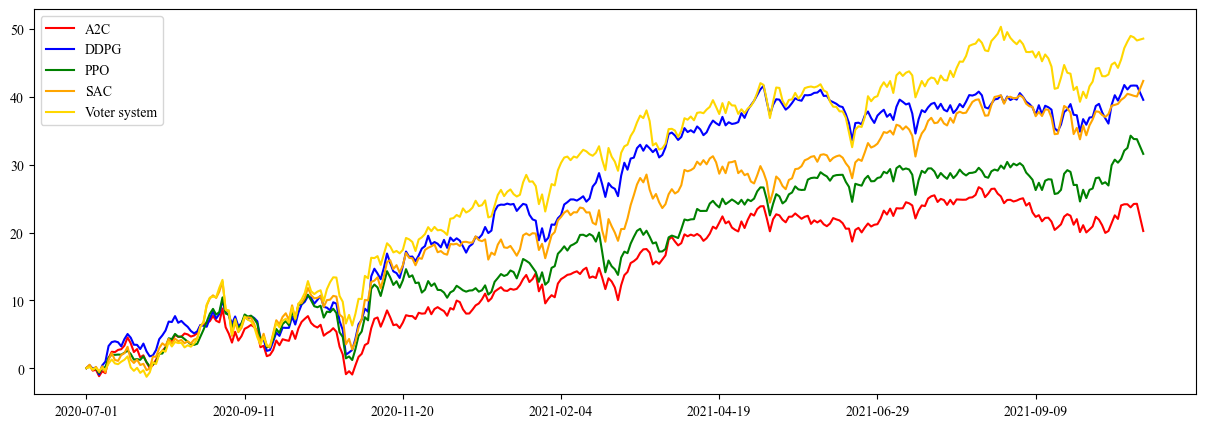

In [28]:
plt.plot(dates, ress_a2c, c='r', label='A2C')
plt.plot(dates, ress_ddpg, c='b', label='DDPG')
plt.plot(dates, ress_ppo, c='g', label='PPO')
plt.plot(dates, ress_sac, c='orange', label='SAC')
plt.plot(dates, ress_vote, c='gold', label='Voter system')
plt.legend()
plt.xticks(ticks_dates)
plt.savefig('./results/reward.png')
plt.show()

In [29]:
ddd = zip(dates, cost_a2c, cost_ddpg, cost_ppo, cost_sac, cost_vote)
df = pd.DataFrame(ddd)
df.columns = ['date', 'cost_a2c', 'cost_ddpg', 'cost_ppo', 'cost_sac', 'cost_vote']
df

,date,cost_a2c,cost_ddpg,cost_ppo,cost_sac,cost_vote
0,2020-07-01,125.303276,149.633932,110.743843,145.979616,44.251478
1,2020-07-02,284.391413,299.633603,253.411528,288.639505,128.004358
2,2020-07-06,459.697164,451.848013,412.563236,455.233081,227.652016
3,2020-07-07,667.216069,602.408298,639.639219,607.148710,314.493045
4,2020-07-08,854.341601,753.483849,855.054235,767.388385,397.033263
...,...,...,...,...,...,...
330,2021-10-21,2815.790215,999.000973,65569.849512,1696.200065,5302.868743
331,2021-10-22,2815.790215,999.000973,65701.990618,1696.200065,5306.679301
332,2021-10-25,2815.790215,999.000973,65942.991620,1696.200065,5327.620105
333,2021-10-26,2848.528217,999.000973,66214.483166,1696.200065,5338.191304


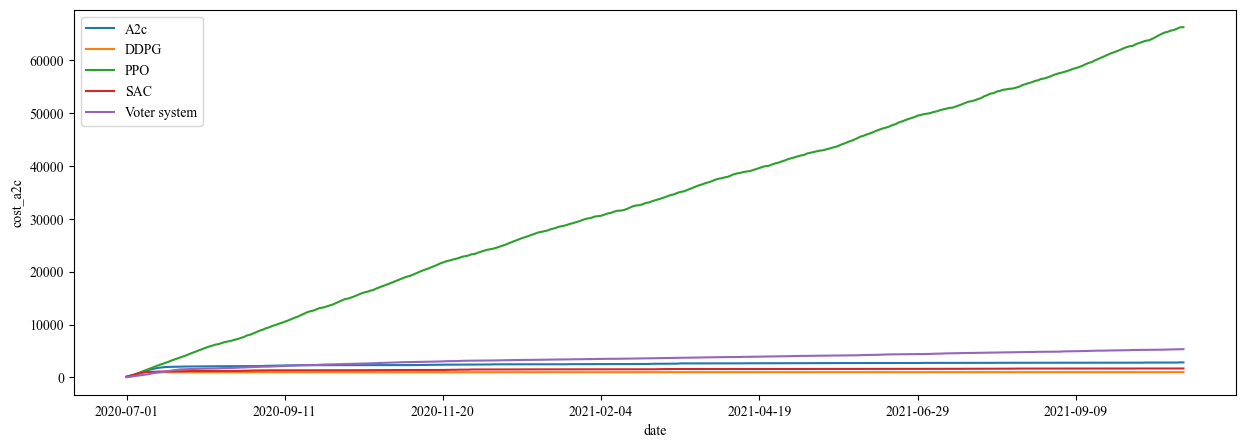

In [30]:
sns.lineplot(data=df, x="date", y="cost_a2c", label='A2c')
sns.lineplot(data=df, x="date", y="cost_ddpg", label='DDPG')
sns.lineplot(data=df, x="date", y="cost_ppo", label='PPO')
sns.lineplot(data=df, x="date", y="cost_sac", label='SAC')
sns.lineplot(data=df, x="date", y="cost_vote", label='Voter system')
plt.xticks(ticks_dates)
plt.legend()

plt.savefig('./results/costs.png')


In [31]:
ddd = zip(dates, trade_a2c, trade_ddpg, trade_ppo, trade_sac, trade_vote)
df = pd.DataFrame(ddd)
df.columns = ['date', 'trade_a2c', 'trade_ddpg', 'trade_ppo', 'trade_sac', 'trade_vote']
df

,date,trade_a2c,trade_ddpg,trade_ppo,trade_sac,trade_vote
0,2020-07-01,13,15,15,16,13
1,2020-07-02,30,30,34,32,29
2,2020-07-06,50,45,56,48,47
3,2020-07-07,73,60,79,64,65
4,2020-07-08,94,75,102,79,82
...,...,...,...,...,...,...
330,2021-10-21,5757,5289,8294,4947,5561
331,2021-10-22,5775,5305,8323,4962,5578
332,2021-10-25,5792,5321,8351,4975,5595
333,2021-10-26,5809,5337,8377,4990,5613


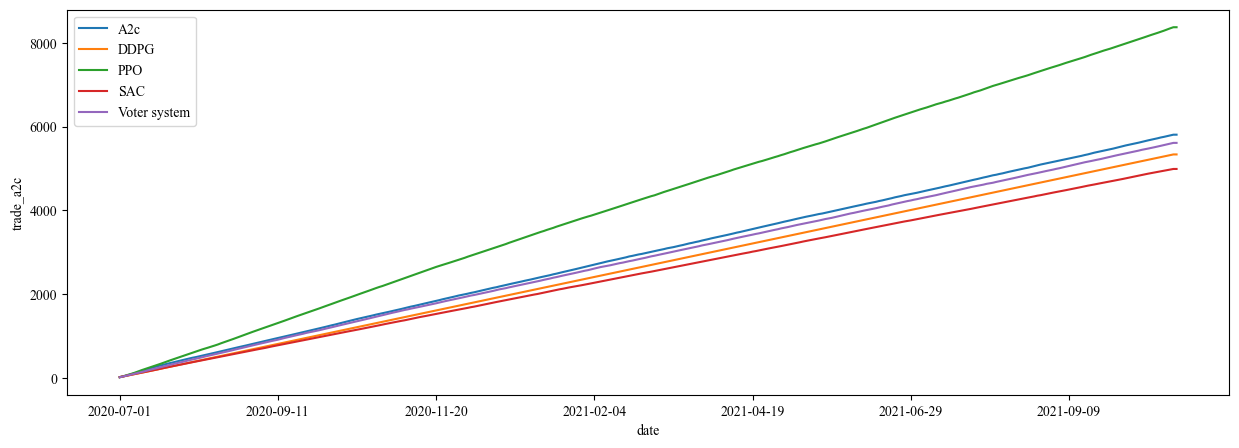

In [32]:
sns.lineplot(data=df, x="date", y="trade_a2c", label='A2c')
sns.lineplot(data=df, x="date", y="trade_ddpg", label='DDPG')
sns.lineplot(data=df, x="date", y="trade_ppo", label='PPO')
sns.lineplot(data=df, x="date", y="trade_sac", label='SAC')
sns.lineplot(data=df, x="date", y="trade_vote", label='Voter system')
plt.xticks(ticks_dates)
plt.legend()

plt.savefig('./results/trade.png')


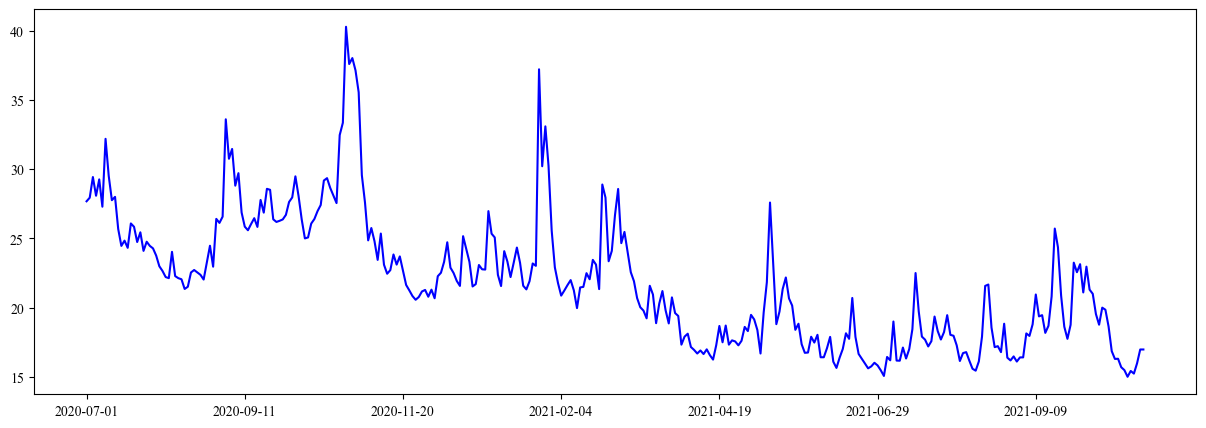

In [33]:
#plt.plot(dates, turbulence_a2c, c='r')
#plt.plot(dates, turbulence_ddpg, c='b')
#plt.plot(dates, turbulence_ppo, c='g')
#plt.plot(dates, turbulence_sac, c='orange')
plt.plot(dates, turbulence_vote, c='b')
ticks_dates = list()
for i in range(len(dates)):
    if i % 50 == 0:
        ticks_dates.append(dates[i])

plt.xticks(ticks_dates)
plt.savefig('./results/turbulence.png')
plt.show()


In [34]:
ddd = zip(cost_a2c, cost_ddpg, cost_ppo, cost_sac, cost_vote, trade_a2c, trade_ddpg, trade_ppo, trade_sac, trade_vote)
df = pd.DataFrame(ddd)
df.columns = ['cost_a2c', 'cost_ddpg', 'cost_ppo', 'cost_sac', 'cost_vote', 'trade_a2c', 'trade_ddpg', 'trade_ppo', 'trade_sac', 'trade_vote']
df

,cost_a2c,cost_ddpg,cost_ppo,cost_sac,cost_vote,trade_a2c,trade_ddpg,trade_ppo,trade_sac,trade_vote
0,125.303276,149.633932,110.743843,145.979616,44.251478,13,15,15,16,13
1,284.391413,299.633603,253.411528,288.639505,128.004358,30,30,34,32,29
2,459.697164,451.848013,412.563236,455.233081,227.652016,50,45,56,48,47
3,667.216069,602.408298,639.639219,607.148710,314.493045,73,60,79,64,65
4,854.341601,753.483849,855.054235,767.388385,397.033263,94,75,102,79,82
...,...,...,...,...,...,...,...,...,...,...
330,2815.790215,999.000973,65569.849512,1696.200065,5302.868743,5757,5289,8294,4947,5561
331,2815.790215,999.000973,65701.990618,1696.200065,5306.679301,5775,5305,8323,4962,5578
332,2815.790215,999.000973,65942.991620,1696.200065,5327.620105,5792,5321,8351,4975,5595
333,2848.528217,999.000973,66214.483166,1696.200065,5338.191304,5809,5337,8377,4990,5613


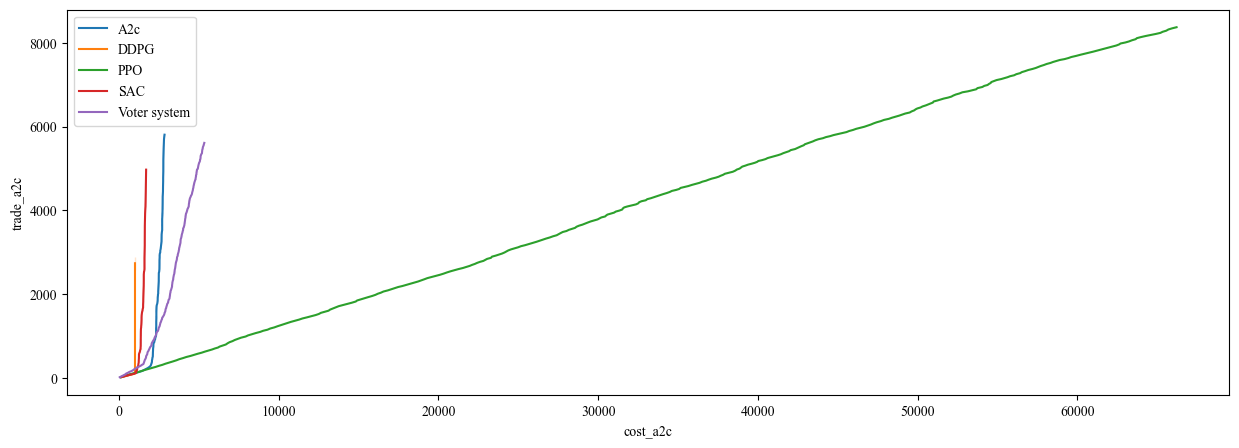

In [35]:
sns.lineplot(data=df, x="cost_a2c", y="trade_a2c", label='A2c')
sns.lineplot(data=df, x="cost_ddpg", y="trade_ddpg", label='DDPG')
sns.lineplot(data=df, x="cost_ppo", y="trade_ppo", label='PPO')
sns.lineplot(data=df, x="cost_sac", y="trade_sac", label='SAC')
sns.lineplot(data=df, x="cost_vote", y="trade_vote", label='Voter system')
plt.legend()

plt.savefig('./results/cost_trade.png')

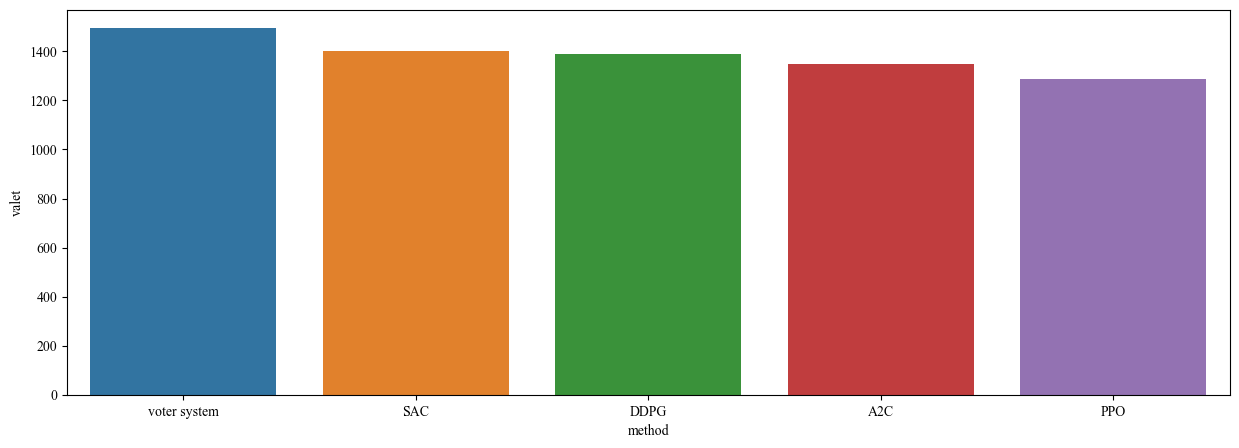

In [36]:
dd = zip([1495, 1403, 1389, 1347, 1286], ['voter system', 'SAC', 'DDPG', 'A2C', 'PPO'])
df = pd.DataFrame(dd)
df.columns = ['valet', 'method']
sns.barplot(data=df, x="method", y="valet")
plt.savefig('./results/barchart.png')
